# Sentiment140 Dataset Analysis

The Fastai framework was used to generate a NLP model used to predict labels for the Sentiment140 dataset. The Sentiment140 dataset contains 1,600,000 tweets from twitter, labeled from 0 (negative) to 4 (positive), and is available for the purpose of performing sentiment analysis.

Most of the variable names in this notebook are consistent with Fastai's documentation, found at: https://docs.fast.ai/

The Sentiment140 Dataset was obtained from Kaggle at the following link: https://www.kaggle.com/kazanova/sentiment140

Note that transfer learning was used with this NLP model. The weights from a pretrained AWD-LSTM language model, stored in Fastai's library, were used as a starting point for this NLP model. The original paper detailing the AWD-LSTM model can be found here: https://arxiv.org/pdf/1708.02182.pdf

## Setup

Activate a virtual environment, then:

In [ ]:
!pip install fastai

## Import Frameworks

In [1]:
# Import frameworks

%reload_ext autoreload
%autoreload 2
%matplotlib inline

from fastai.text import *

In [ ]:
# Unzip sentiment140.zip from the folder where it is stored (only need to do this once)
!unzip "./data/sentiment/sentiment140.zip"

### Data Preparation

In [2]:
# Read CSV File

filename = "training.1600000.processed.noemoticon.csv"
path = "" # The csv gets unzipped to the current directory
df = pd.read_csv(filename, header=None, usecols=[0,5], names=["label","text"], encoding='latin-1')

df.head() # show part of file

,label,text
0,0,"@switchfoot http://twitpic.com/2y1zl - Awww, t..."
1,0,is upset that he can't update his Facebook by ...
2,0,@Kenichan I dived many times for the ball. Man...
3,0,my whole body feels itchy and like its on fire
4,0,"@nationwideclass no, it's not behaving at all...."


#### Organize Data for Language & Classification Models

In [3]:
# Prepare Dataframe into Training, Validation, and Test Sets

# Randomize data
df = df.iloc[np.random.permutation(len(df))]

# Percent of original dataframe
test_pct = 0.1
valid_pct = 0.2

# Masks for separating dataframe sets
cut_test = int(test_pct * len(df))+1
cut_valid = int(valid_pct*len(df))+cut_test

train_df = df[cut_valid:]
valid_df = df[cut_test:cut_valid]
test_df = df[:cut_test]

len(train_df), len(valid_df), len(test_df) # show lengths of each set

(1119999, 320000, 160001)

In [4]:
# Initialize Language Model Data

data_lm = TextLMDataBunch.from_df(path=path,train_df=train_df,
                                  valid_df=valid_df,test_df=test_df)
data_lm.save('data_lm_export.pkl')

data_lm.show_batch() # show batch of language model data

idx,text
0,sweet ! xxmaj haha but here i am lying in bed feeling super sick xxbos xxup wtf .. xxmaj now we got lightning but no thunder & & no rain ... xxmaj spooky xxbos xxmaj whoohoo ! update from phone . xxbos thinks up was the best animated movie in the world . xxmaj happy the xxup 3-d was low key xxbos xxunk xxup :o xxmaj what is this creepy
1,nt have it . xxbos xxmaj xxunk tomorrow is monday ! xxmaj counting my days to xxunk date of xxup moe xxbos debating on going outside xxbos xxunk xxmaj it 's 65 xxmaj my subscription ends xxmaj may 15th . n xxrep 6 o ! i need money :'( xxbos xxmaj donna your sister - in - law xxrep 4 . you must make the reunion next year . xxmaj
2,n't gotten a good night sleep since this season started xxbos xxunk xxmaj that 's awful . xxmaj how do you think they got in ? xxbos all house chores complete bored now luckily still very excited about j so he keeping me smiling xxbos xxunk partying at the xxmaj xxunk http : / / tinyurl.com / xxunk xxbos i can finally say that im ... xxup happy ! !
3,"as stressed xxunk 2 my parents , they are now driving to xxmaj portsmouth as my aunt died xxbos @mileycyrus mmm what feeling girl ? ? lov ya and if u need help , i 'm here ! kisses from argentina <333 xxbos @katehughes xxmaj you 've got a plastic penguin ? xxmaj so jealous xxbos 5th year timetable is balls double english then double maths tomorrow .. not looking"
4,"4 a tax accountant xxbos xxunk i recieved a voice message about a child i apparently am not taking care of xxbos just played some football , i scored a few so i m happy , now gunna watch some one tree hill xxbos xxunk i ai nt even trying to shout lol xxwrep 4 x i do nt even sound husky sexy , @faulko1 says more xxunk / ashley"


In [5]:
# Initialize Classification Model Data

data_clas = TextClasDataBunch.from_df(path=path,train_df=train_df, valid_df=valid_df,
                                      test_df=test_df, vocab=data_lm.train_ds.vocab)
data_clas.save('data_clas_export.pkl')

data_clas.show_batch() # show batch of classification model data

text,target
xxbos human shield à ® à ® © à¯?à ® xxunk à ® xxunk ® ±à¯?à ® xxunk ® à ® ° xxunk à ® à ® © à¯?à ® xxunk ? à ® ® à ® ±à¯?à ® ªà ® à ® ¿à ® xxunk ® ® à¯ ? à ® xxunk ® à ® à ® à¯?à ® à ® xxunk ® ¿à ® xxunk ? ( à,0
"xxbos xxup ma xxup mummy xxup got xxup my xxup clan xxup hoodie xxup today ! ! ! xxup she xxup opened xxup it xxup for xxup me xxup and xxup now xxup she xxup wants xxup to xxup keep xxup it xxup no xxup way ! ! xxup it xxup has a xxup note xxup from xxup pete , xxup something xxup about",4
xxbos xxmaj wake xxmaj up ! @kbuech : & ' xxmaj gun 's & & xxmaj roses - & ' xxmaj sweet xxmaj child o ' xxmaj mine & ' ( xxmaj music xxmaj video ) xxup good xxup morning xxunk : xxmaj good mo ... â « http : / / blip.fm / xxunk,4
"xxbos http : / / tr.im / xxunk ï¿½ xxmaj xxunk ? xxmaj not xxmaj belong xxmaj here ( xxmaj xxunk a xxmaj remix ) , xxrep 5 ? xxrep 8 ? xxrep 4 ? , xxrep 7 ? xxrep 9 ? ? ? xxrep 4 ? xxrep 5 ?",4
xxbos xxmaj alt . xxmaj christ - on - a - bike - athon going v badly . xxmaj xxunk on a moped ? xxmaj jehovah in a landrover ? xxmaj xxunk in a .. van ? xxmaj ra in a xxmaj car ? xxmaj zeus on a bus ?,0


Note the following tokens are automatically used by fastai's DataBunch class:
- UNK (xxunk) is for an unknown word (one that isn't present in the current vocabulary)
- PAD (xxpad) is the token used for padding, if we need to regroup several texts of different lengths in a batch
- BOS (xxbos) represents the beginning of a text in your dataset
- FLD (xxfld) is used if you set mark_fields=True in your TokenizeProcessor to separate the different fields of texts (if your texts are loaded from several columns in a dataframe)
- TK_MAJ (xxmaj) is used to indicate the next word begins with a capital in the original text
- TK_UP (xxup) is used to indicate the next word is written in all caps in the original text
- TK_REP (xxrep) is used to indicate the next character is repeated n times in the original text (usage xxrep n {char})
- TK_WREP(xxwrep) is used to indicate the next word is repeated n times in the original text (usage xxwrep n {word})


#### Load Previously Initialized Data

Once the data has been organized and saved, the following cell can be used whenever the kernel is restarted (allowing you to skip all the steps under "Organize Data" above)

In [3]:
# Load Previously Initialized Model Data

data_lm = load_data(path, 'data_lm_export.pkl')
data_clas = load_data(path, 'data_clas_export.pkl', bs=16)

In [5]:
data_clas.show_batch(), data_lm.show_batch()

text,target
xxbos human shield à ® xxunk ® © à¯?à ® xxunk à ® xxunk ® xxunk ® xxunk ® à ® ° xxunk à ® xxunk ® © à¯?à ® xxunk ? à ® ® à ® xxunk ® ªà ® à ® ¿à ® xxunk ® ® à¯ ? à ® xxunk ® à ® à ® xxunk ® à ® xxunk ® ¿à ® xxunk ? ( à,0
xxbos ' xxmaj xxunk xxmaj xxunk 's q xxmaj and a ' and ' xxmaj the xxmaj white xxmaj tiger ' are the # books in my dad 's next plans to buy . xxmaj yippie ! ! i too can read them,4
xxbos xxmaj hope every1 is havin a good time in xxup nyc for the xxup pr parade after parties ... i 'm at xxmaj mansion wit my xxmaj baby and my xxmaj xxunk xxmaj happy xxmaj bday 2 xxup me,4
xxbos is sitting at xxmaj beckie 's watching an xxmaj angel game . i do n't know if it 's today 's game or not . xxmaj and i can not find the remote . xxmaj phone is dead .,0
"xxbos xxunk xxup whats xxup going xxup on ? ! xxmaj ah , haha . xxmaj ca n't he just tell me what 's up . xxmaj now only xxup two of his cousins are in front of me ...",4


idx,text
0,". xxbos xxunk i have it on dvr if you wish to partake xxbos i found a xxup huge bag of skittles when i went downstairs , and i dug right in ... now my teeth hurt xxrep 4 . lol xxbos xxmaj ordered my customized shirt on xxunk xxbos i d be better off without weather like this .. xxmaj sittin in the water heater closet in the garage"
1,made grant pinky promise me not to touch any girls ' butts at the eighth grade dance hahah i always have a good time at markie 's house xxbos can not sleep xxbos xxmaj now i 've stopped using it because the xxup ui xxup really needs polish . xxmaj miss a key and you click the mouse = bad xxup ui design . xxmaj awkward xxmaj keyboard layout xxbos
2,"xxmaj xxunk xxmaj way : http : / / bit.ly / xxunk xxmaj great interview ! xxbos xxunk ditto 46 = d xxbos xxmaj worked a xxmaj regional xxmaj special xxmaj olympics event today handing out medals to the athletes xxmaj awesome ! xxmaj amazing kids and adults xxbos stupid rain , now our picnic is cancelled till tomorrow xxbos xxunk xxmaj wow ! i am impressed xxmaj pastor xxmaj"
3,"_ did you tell your mom bout our xxunk twins thing ? xxbos xxup is xxup really xxup not xxup happy xxup with xxup all xxup the xxup gnat xxup bites xxup on xxup my xxup legs xxbos xxmaj back xxunk work , my back if bloody killing me and i 'm in dire need of coffee and some pain relief xxbos xxmaj the rain xxunk to xxmaj dallas ."
4,xxmaj xxunk & ' xxbos happy friday to all of my early morning tweetie pies xxrep 4 . today is gon na be a good day ... i can feel it xxbos xxunk xxmaj thanks ! i guess i 'm almost done with the 1st trimester . 10 weeks or so ? xxmaj it 's # 3 so we 'll see how that goes . xxbos xxunk xxmaj that 's


(None, None)

## Model Training

### Language Model



The following structure was used with fastai's language_model_learner.

AWD_LSTM is a pretrained model stored in fastai

    model=SequentialRNN(
      (0): AWD_LSTM(
        (encoder): Embedding(60000, 400, padding_idx=1)
        (encoder_dp): EmbeddingDropout(
          (emb): Embedding(60000, 400, padding_idx=1)
        )
        (rnns): ModuleList(
          (0): WeightDropout(
            (module): LSTM(400, 1152, batch_first=True)
          )
          (1): WeightDropout(
            (module): LSTM(1152, 1152, batch_first=True)
          )
          (2): WeightDropout(
            (module): LSTM(1152, 400, batch_first=True)
          )
        )
        (input_dp): RNNDropout()
        (hidden_dps): ModuleList(
          (0): RNNDropout()
          (1): RNNDropout()
          (2): RNNDropout()
        )
      )
      (1): LinearDecoder(
        (decoder): Linear(in_features=400, out_features=60000, bias=True)
        (output_dp): RNNDropout()
      )
    ), opt_func=functools.partial(<class 'torch.optim.adam.Adam'>, betas=(0.9, 0.99)), loss_func=FlattenedLoss of CrossEntropyLoss(), metrics=[<function accuracy at 0x7fa11278d170>], true_wd=True, bn_wd=True, wd=0.01, train_bn=True, path=PosixPath('.'), model_dir='models', callback_fns=[functools.partial(<class 'fastai.basic_train.Recorder'>, add_time=True, silent=False)], callbacks=[RNNTrainer
    learn: ...
    alpha: 2.0
    beta: 1.0], layer_groups=[Sequential(
      (0): WeightDropout(
        (module): LSTM(400, 1152, batch_first=True)
      )
      (1): RNNDropout()
    ), Sequential(
      (0): WeightDropout(
        (module): LSTM(1152, 1152, batch_first=True)
      )
      (1): RNNDropout()
    ), Sequential(
      (0): WeightDropout(
        (module): LSTM(1152, 400, batch_first=True)
      )
      (1): RNNDropout()
    ), Sequential(
      (0): Embedding(60000, 400, padding_idx=1)
      (1): EmbeddingDropout(
        (emb): Embedding(60000, 400, padding_idx=1)
      )
      (2): LinearDecoder(
        (decoder): Linear(in_features=400, out_features=60000, bias=True)
        (output_dp): RNNDropout()
      )
    )], add_time=True, silent=False, cb_fns_registered=False)

LR Finder is complete, type {learner_name}.recorder.plot() to see the graph.
Min numerical gradient: 3.98E-02
Min loss divided by 10: 3.63E-02


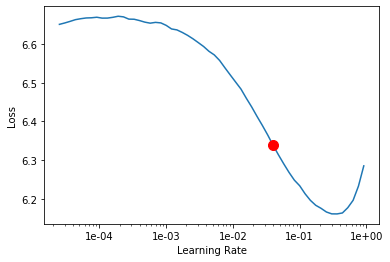

In [6]:
learn = language_model_learner(data_lm, AWD_LSTM, drop_mult=0.3)
learn.lr_find()
learn.recorder.plot(skip_start=30,skip_end=12,suggestion=True)

In [7]:
learn.fit_one_cycle(1, 1e-2, moms=(0.8,0.7))
learn.save('sentiment_head')

epoch,train_loss,valid_loss,accuracy,time
0,4.492013,4.349950,0.241083,38:55


LR Finder is complete, type {learner_name}.recorder.plot() to see the graph.
Min numerical gradient: 8.32E-04
Min loss divided by 10: 1.45E-04


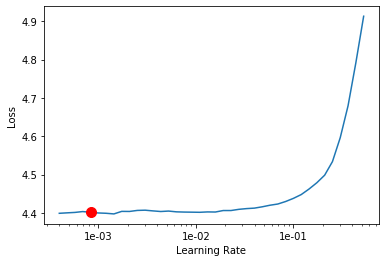

In [8]:
learn.load('sentiment_head')
learn.lr_find()
learn.recorder.plot(skip_start=45,skip_end=15,suggestion=True)

Min numerical gradient: 1.91E-04
Min loss divided by 10: 6.31E-08


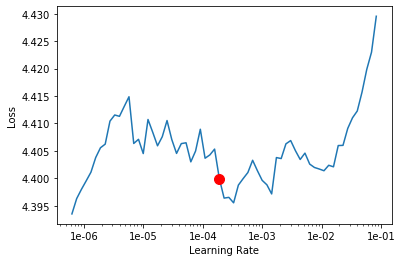

In [13]:
learn.recorder.plot(skip_start=10,skip_end=25,suggestion=True)

In [14]:
lr = 1e-3 # learning rate

In [15]:
learn.predict("What on earth is",100,temperature=1.1,min_p=0.001)

"What on earth is always a matter to each , now we think the name ? There are 2 times in the world when people use them xxbos Just waiting to do things to go ! http : / / tr.im / sunnyinseattle xxbos Sometimes ... xxbos My internet connection has nt been the same lately . Damn ... So proud of today ! . i feel a little bit sorry to see you when that happens . http : / / bit.ly / votetom spread the word ! ! It 's cold . xxbos no"

In [16]:
learn.unfreeze()
learn.fit_one_cycle(1, lr, moms=(0.8,0.7)) # could train this for more epochs...
learn.save('sentiment_tuned')
learn.save_encoder('sentiment_enc')

epoch,train_loss,valid_loss,accuracy,time
0,4.066004,4.010943,0.281111,44:10


In [17]:
learn.predict("What on earth is",100,temperature=1.1,min_p=0.001)

"What on earth is wrong with all of you ? ? ? Why oh why oh why do n't we all feel like xxbos Woke up and had to study for maths but i do n't mind . One more lesson ... xxbos my leg is sore from biking with the cab . xxbos just took a long walk away from the office it was the best of you there is no fair * * * xxbos Playing in front of some random people . Just curious to hear it xxbos is n't going to my school till 3"

## Classification

### Model Structure

The following model structure was used with fastai's text_classifier_learner

      (0): MultiBatchEncoder(
        (module): AWD_LSTM(
          (encoder): Embedding(60000, 400, padding_idx=1)
          (encoder_dp): EmbeddingDropout(
            (emb): Embedding(60000, 400, padding_idx=1)
          )
          (rnns): ModuleList(
            (0): WeightDropout(
              (module): LSTM(400, 1152, batch_first=True)
            )
            (1): WeightDropout(
              (module): LSTM(1152, 1152, batch_first=True)
            )
            (2): WeightDropout(
              (module): LSTM(1152, 400, batch_first=True)
            )
          )
          (input_dp): RNNDropout()
          (hidden_dps): ModuleList(
            (0): RNNDropout()
            (1): RNNDropout()
            (2): RNNDropout()
          )
        )
      )
      (1): PoolingLinearClassifier(
        (layers): Sequential(
          (0): BatchNorm1d(1200, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
          (1): Dropout(p=0.2)
          (2): Linear(in_features=1200, out_features=50, bias=True)
          (3): ReLU(inplace)
          (4): BatchNorm1d(50, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
          (5): Dropout(p=0.1)
          (6): Linear(in_features=50, out_features=2, bias=True)
        )
      )
    ), opt_func=functools.partial(<class 'torch.optim.adam.Adam'>, betas=(0.9, 0.99)), loss_func=FlattenedLoss of CrossEntropyLoss(), metrics=[<function accuracy at 0x7fa11278d170>], true_wd=True, bn_wd=True, wd=0.01, train_bn=True, path=PosixPath('.'), model_dir='models', callback_fns=[functools.partial(<class 'fastai.basic_train.Recorder'>, add_time=True, silent=False)], callbacks=[RNNTrainer
    learn: ...
    alpha: 2.0
    beta: 1.0], layer_groups=[Sequential(
      (0): Embedding(60000, 400, padding_idx=1)
      (1): EmbeddingDropout(
        (emb): Embedding(60000, 400, padding_idx=1)
      )
    ), Sequential(
      (0): WeightDropout(
        (module): LSTM(400, 1152, batch_first=True)
      )
      (1): RNNDropout()
    ), Sequential(
      (0): WeightDropout(
        (module): LSTM(1152, 1152, batch_first=True)
      )
      (1): RNNDropout()
    ), Sequential(
      (0): WeightDropout(
        (module): LSTM(1152, 400, batch_first=True)
      )
      (1): RNNDropout()
    ), Sequential(
      (0): PoolingLinearClassifier(
        (layers): Sequential(
          (0): BatchNorm1d(1200, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
          (1): Dropout(p=0.2)
          (2): Linear(in_features=1200, out_features=50, bias=True)
          (3): ReLU(inplace)
          (4): BatchNorm1d(50, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
          (5): Dropout(p=0.1)
          (6): Linear(in_features=50, out_features=2, bias=True)
        )
      )
    )], add_time=True, silent=False, cb_fns_registered=True)

LR Finder is complete, type {learner_name}.recorder.plot() to see the graph.
Min numerical gradient: 1.74E-03
Min loss divided by 10: 2.09E-02


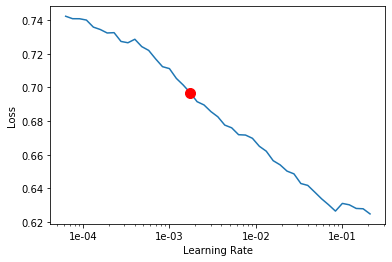

In [18]:
learn = text_classifier_learner(data_clas, AWD_LSTM, drop_mult=0.5)
learn.load_encoder('sentiment_enc')
learn.lr_find()
learn.recorder.plot(skip_start=35,skip_end=14,suggestion=True)

Min numerical gradient: 1.74E-03
Min loss divided by 10: 2.51E-02


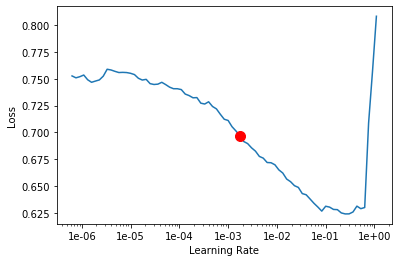

In [19]:
learn.recorder.plot(suggestion=True)

In [20]:
learn.fit_one_cycle(1, 2e-2, moms=(0.8,0.7))
learn.save('sentiment_first')

epoch,train_loss,valid_loss,accuracy,time
0,0.448023,0.403974,0.814572,10:50


In [24]:
learn.load('sentiment_first');
learn.freeze_to(-2)
learn.fit_one_cycle(1, slice(1e-2/(2.6**4),1e-2), moms=(0.8,0.7))
learn.save('sentiment_second')

epoch,train_loss,valid_loss,accuracy,time
0,0.385381,0.366896,0.846656,11:53


In [25]:
learn.load('sentiment_second');
learn.freeze_to(-3)
learn.fit_one_cycle(1, slice(5e-3/(2.6**4),5e-3), moms=(0.8,0.7))
learn.save('sentiment_third')

epoch,train_loss,valid_loss,accuracy,time
0,0.368541,0.326588,0.857725,19:18


In [26]:
learn.load('sentiment_third');
learn.unfreeze()
learn.fit_one_cycle(2, slice(1e-3/(2.6**4),1e-3), moms=(0.8,0.7))
learn.save('sentiment_fourth')

epoch,train_loss,valid_loss,accuracy,time
0,0.332930,0.321300,0.861003,30:40
1,0.312041,0.318390,0.862575,29:26


## Model Predictions

In [23]:
learn.predict("You're not a terrible person. I love you so much")

(Category 4, tensor(1), tensor([0.3544, 0.6456]))

In [28]:
learn.predict("You're a terrible person. I hate you")

(Category 0, tensor(0), tensor([0.8306, 0.1694]))

    Category 0 - Negative
    Category 2 - Neutral
    Category 4 - Positive